# Rock Paper Scissor Code


# Group Members


1.   Amol Prakash
1.   Rithwik Chhugani
2.   Jivitesh Sharma




# Limitation


*   Limited dataset is not only a limitation but it's one of the things we should focus on. In real world not everytime we'll find a plethora of data to train our model, so the model should be able to classify based on the limited number of images it is provided for training. 
*   Limited computational power. Colab's dedicated ram and gpu are very limited and are not sufficient enough to train a robust model or a model with a lot of data. 


# Future Prospect


*   The model could be kept running for a longer time
*   Optimization techniques like GridSearchCV or Bayesian Optimization could be used provided we have the required hardware architecture.
*   Image augmentation could be used with higher ram available
*   For our case, we didn't have images that belong to the same class but still are of a different variant, for e.g. classifying different breeds of dogs, in that case we could have also used the neighbor loss concpet to make the model robust to such images.
*   Last but not the least, the model works decently on pure images but it is not optimized to handle pertubed images, one of the popular adverserial attach techniques know as Fast Gradient Sign Method (FGSM) introduces some noise to the images but if you print out the image it will look identical. Keras provides us with the functionality to train our model on such pertubed images as well. 





# Trial, Error and Findings


*   We used the VGG-19 network to compare the performance of our model and it turned out to be close. 
*   We tried using the KerasTuner to hyper tune the parameters in different layers but the output wasn't satisfactory. Since keras tuner works on a random search method the parameters are randomly assigned which don't help the model to learn better rather hampers it's progress. 
*   In this case Bayesian Optimization with a lot of iterations would have been a better method.
*   We tried adding and deleting layers but we found out that anything beyond 4 convolutional layers was giving good scores. 
*   We tried adding different number of dense layers as well but the best was to have one dense layer after flatten and then the last layer for the classification output.
*   We tried using Maxpooling layer at the beginning of the network with different hyperparameters but it turns out that Averagepooling is a better choice to help the model learn in a better fashion.
*   We tried different optimizers, but all the other optimizers except Adam were taking a significanlty longer time to execute per epoch.
*   We tried using learning rate scheduler but didn't really affect our accuracy or loss significantly. 
*   Because of the images being in 4k format we had to convert the images to numpy arrays to be able to work with image data. 
*   We did try adding more images, and increasing the batch size for faster and better learning but Google Colab kept on crashing as it wasn't able to allocate the required ram and gpu power. 







In [1]:
# importing the required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dense,Activation
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.image as mpimg
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from numpy import expand_dims

In [2]:
# mounting the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# printing out the count of images in each of the three folder in the google drive
import os
print('Number of folders found: ',len(os.listdir('/content/drive/MyDrive/DataMiningProjectData')))
print ('Number of rock images: ', len(os.listdir('/content/drive/MyDrive/DataMiningProjectData/Rock')))
print ('Number of paper images: ', len(os.listdir('/content/drive/MyDrive/DataMiningProjectData/Paper')))
print ('Number of scissors images: ', len(os.listdir('/content/drive/MyDrive/DataMiningProjectData/Scissor')))
total_images = len(os.listdir('/content/drive/MyDrive/DataMiningProjectData/Rock')) + len(os.listdir('/content/drive/MyDrive/DataMiningProjectData/Paper')) + len(os.listdir('/content/drive/MyDrive/DataMiningProjectData/Scissor'))

Number of folders found:  3
Number of rock images:  212
Number of paper images:  194
Number of scissors images:  229


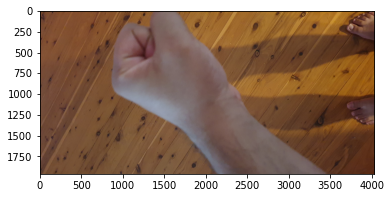

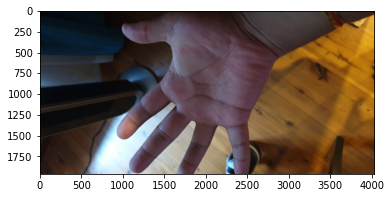

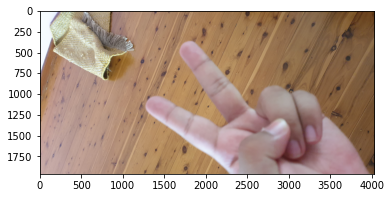

In [4]:
# printing out one image from each of the folders
# originally most of the images are of size 4032 x 1960
rock_images = os.listdir('/content/drive/MyDrive/DataMiningProjectData/Rock')
paper_images = os.listdir('/content/drive/MyDrive/DataMiningProjectData/Paper')
scissors_images = os.listdir('/content/drive/MyDrive/DataMiningProjectData/Scissor')
rock_images  = ['/content/drive/MyDrive/DataMiningProjectData/Rock/'+ i for i in rock_images]
paper_images  = ['/content/drive/MyDrive/DataMiningProjectData/Paper/'+ i for i in paper_images]
scissors_images  = ['/content/drive/MyDrive/DataMiningProjectData/Scissor/'+ i for i in scissors_images]
for img_path in [rock_images[1],paper_images[1],scissors_images[1]]:
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('On')
  plt.show()

In [ ]:
# building an object to perform image augmentation 
# training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 50,
#                                                                    width_shift_range = 0.3,
#                                                                    height_shift_range = 0.3,
#                                                                    shear_range = 0.3,
#                                                                    vertical_flip = True,
#                                                                    fill_mode = 'nearest',
#                                                                    zoom_range = [0.2,0.5],
#                                                                    horizontal_flip = True,
#                                                                    )

In [5]:
#labelling the data for train
import glob

Rock_dir = '/content/drive/MyDrive/DataMiningProjectData/Rock/'
Paper_dir = '/content/drive/MyDrive/DataMiningProjectData/Paper/'
Scissor_dir = '/content/drive/MyDrive/DataMiningProjectData/Scissor/'

# Get the list of all the images
Rock_Images = os.listdir(Rock_dir)
Paper_Images = os.listdir(Paper_dir)
Scissor_Images = os.listdir(Scissor_dir)


# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# labelling images for rock
for img in Rock_Images:
    train_data.append((Rock_dir+img,0))

# labelling images for paper
for img in Paper_Images:
    train_data.append((Paper_dir+img, 1))

# labelling images 
for img in Scissor_Images:
    train_data.append((Scissor_dir+img, 2))

train_Image_data=[i for (i,j) in train_data]
train_Label_data=[j for (i,j) in train_data]

In [6]:
#labelling the data for Validation
import glob

Rock_Val_dir = '/content/drive/MyDrive/DataMiningProjectDataValidation/Rock/'
Paper_Val_dir = '/content/drive/MyDrive/DataMiningProjectDataValidation/Paper/'
Scissor_Val_dir = '/content/drive/MyDrive/DataMiningProjectDataValidation/Scissor/'

# Get the list of all the images
Rock_Val_Images = os.listdir(Rock_Val_dir)
Paper_Val_Images = os.listdir(Paper_Val_dir)
Scissor_Val_Images = os.listdir(Scissor_Val_dir)


# An empty list. We will insert the data into this list in (img_path, label) format
Val_data = [] 

#Leaving 10 images for testing 

for img in Rock_Val_Images:
    Val_data.append((Rock_Val_dir+img,0))

for img in Paper_Val_Images:
    Val_data.append((Paper_Val_dir+img, 1))

for img in Scissor_Val_Images:
    Val_data.append((Scissor_Val_dir+img, 2))

Val_Image_data=[i for (i,j) in Val_data]
Val_Label_data=[j for (i,j) in Val_data]

In [7]:
#creating test data and viewing if our seed worked
import random 

#test_data=[]
#test_labels=[]
Test_tuple=random.sample(list(zip(Val_Image_data,Val_Label_data)),10)
Test_data=[i for (i,j) in Test_tuple]
Test_label=[j for (i,j) in Test_tuple] 



print(Test_data[6] )
print(Test_label[6])

#image = Image.open(Test_data[2]) 
#image.resize((540,245)) 
#print(Test_labels[2]) 

#popping out the elements and their corresponding labels from the Validation set
for i in Test_data:
  index=Val_Image_data.index(i) 
  Val_Image_data.pop(index)
  Val_Label_data.pop(index)

/content/drive/MyDrive/DataMiningProjectDataValidation/Paper/20201225_203838.jpg
1


In [31]:
# upon experimenting with different values we decided to resize the image to 1008 x 490 store it inside an array
Image_array=[]
for  i in train_Image_data:
  Image_array.append(np.array(Image.open(i).resize((1008,490)))) 

In [32]:
# creating array for the validation images
Image_Val_array=[]
for  i in Val_Image_data:
  Image_Val_array.append(np.array(Image.open(i).resize((1008,490))))

In [33]:
# creating an array for the test images
Image_test_array=[]
for i in Test_data:
  Image_test_array.append(np.array(Image.open(i).resize((1008,490))))

In [12]:
# dumping both the array to save time
# Image_array.dump('image_array.npy')
# Image_Val_array.dump('image_val_array.npy')

In [34]:
#convert to float and normalize training data
Image_array=np.array(Image_array)
Image_array=Image_array.astype('float32') 
Image_array/=255

In [35]:
#convert to float and normalize validation data
Image_Val_array=np.array(Image_Val_array)
Image_Val_array=Image_Val_array.astype('float32') 
Image_Val_array/=255

In [36]:
# convert to float and normalize test data
Image_test_array=np.array(Image_test_array)
Image_test_array=Image_test_array.astype('float32')
Image_test_array/=255

In [37]:
train_Label_data=np.array(train_Label_data)
Val_Label_data=np.array(Val_Label_data)
Test_label=np.array(Test_label)

In [38]:
# printing shapes of all arrays
print(Image_array.shape)
print(train_Label_data.shape)
print(Image_Val_array.shape)
print(Val_Label_data.shape) 
print(Image_test_array.shape)
print(Test_label.shape) 

(635, 490, 1008, 3)
(635,)
(154, 490, 1008, 3)
(154,)
(10, 490, 1008, 3)
(10,)


For the sake of comparison we have taken 3 different models for classification with varying layers and hyperparameters.

We first run our Model by using the MaxPool as our first layer- We try both MaxPool and AvergaePooling archirectures the key difference between them being that AveragePooling preserves more information but doesnt strongly bring forth the the features when compared to MaxPool as intead of taking the maximium value of the current pixels in the window it takes an average of those values, inturn the feature that are extracted are much smoother than that of the feautures extrcated from MaxPool 

Although there is no clear better option, both seem to outperfrom one or the other on a cases to case basis depending on the data that is being looked at, thus in this study we explore both these option

# Model 1

In [39]:
# average pool model with relu
from tensorflow import keras
model_relu= keras.Sequential([keras.layers.AveragePooling2D(6,3,input_shape=(490,1008,3)),
                         keras.layers.Conv2D(64,3, activation='relu',padding='same'),
                         keras.layers.MaxPooling2D(2,2,padding='same'),
                         keras.layers.Conv2D(64,3,activation='relu',padding='same'),
                         keras.layers.MaxPooling2D(2,2,padding='same'),
                         keras.layers.Conv2D(128,3,activation='relu',padding='same'),
                         keras.layers.MaxPooling2D(2,2),
                         keras.layers.Conv2D(128,3,activation='relu',padding='same'),
                         keras.layers.MaxPooling2D(2,2,padding='same'),
                         keras.layers.Flatten(),
                         keras.layers.Dropout(0.5),
                         keras.layers.Dense(512, activation='relu'),
                         keras.layers.Dense(3, activation='softmax')       
                        ])  


model_relu.compile(optimizer='adam', loss= keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history_relu=model_relu.fit(Image_array,train_Label_data,epochs=100,batch_size=32,validation_data=(Image_Val_array,Val_Label_data))

Epoch 1/100
20/20 [==============================] - 6s 228ms/step - loss: 1.2706 - accuracy: 0.3082 - val_loss: 1.0849 - val_accuracy: 0.3896
Epoch 2/100
20/20 [==============================] - 3s 162ms/step - loss: 1.1005 - accuracy: 0.3457 - val_loss: 1.0886 - val_accuracy: 0.3896
Epoch 3/100
20/20 [==============================] - 3s 171ms/step - loss: 1.0963 - accuracy: 0.3621 - val_loss: 1.1030 - val_accuracy: 0.3896
Epoch 4/100
20/20 [==============================] - 3s 167ms/step - loss: 1.1002 - accuracy: 0.3594 - val_loss: 1.0974 - val_accuracy: 0.3896
Epoch 5/100
20/20 [==============================] - 3s 176ms/step - loss: 1.0922 - accuracy: 0.3678 - val_loss: 1.0905 - val_accuracy: 0.4091
Epoch 6/100
20/20 [==============================] - 3s 172ms/step - loss: 1.0855 - accuracy: 0.3653 - val_loss: 1.0468 - val_accuracy: 0.3896
Epoch 7/100
20/20 [==============================] - 4s 179ms/step - loss: 1.0825 - accuracy: 0.4101 - val_loss: 1.1123 - val_accuracy: 0.2273

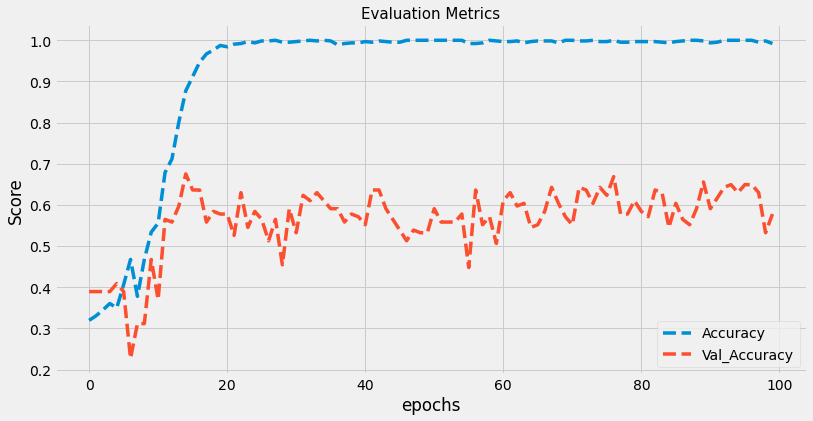

In [40]:
# train vs val accuracy for model_relu
import matplotlib.pyplot as plt
acc=history_relu.history['accuracy']
val_acc=history_relu.history['val_accuracy']
loss=history_relu.history['loss']
val_loss=history_relu.history['val_loss']
epochs=range(len(acc))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(epochs,acc,label = 'Accuracy',ls='--',lw=3.5)
plt.plot(epochs,val_acc,label = 'Val_Accuracy',ls='--',lw=3.5)
plt.title('Evaluation Metrics',size=15)
plt.ylabel('Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

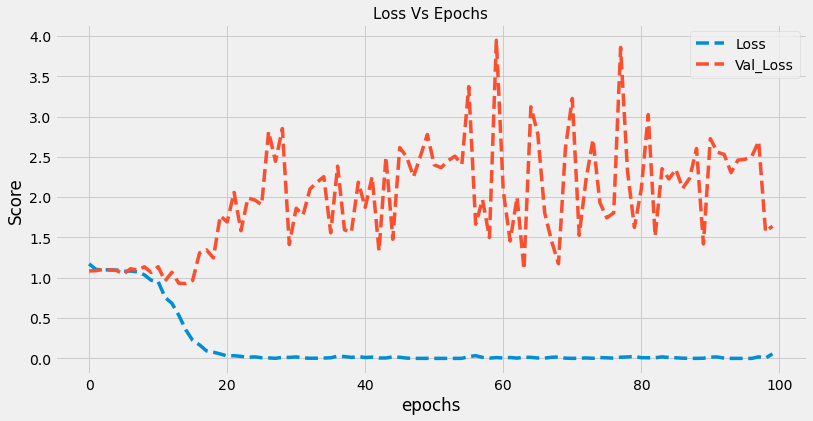

In [41]:
# train loss vs val loss for model_relu
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(epochs,loss,label = 'Loss',ls='--',lw=3.5)
plt.plot(epochs,val_loss,label = 'Val_Loss',ls='--',lw=3.5)
plt.title('Loss Vs Epochs',size=15)
plt.ylabel('Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Model 2


In [42]:
# model with maxpool layer as the first layer
from tensorflow import keras
model_max_pool= keras.Sequential([keras.layers.MaxPooling2D(6,3,input_shape=(490,1008,3)),
                                          
                         keras.layers.Conv2D(64,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2,padding='same'),

                         keras.layers.Conv2D(64,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2,padding='same'),

                         keras.layers.Conv2D(128,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2),

                         keras.layers.Conv2D(128,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2,padding='same'),

                         keras.layers.Flatten(),
                         keras.layers.Dropout(0.5),
                         keras.layers.Dense(512),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.Dense(3, activation='softmax')       
                        ])  

#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
 #   decay_steps=10000,
 #   decay_rate=0.9)
#optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_max_pool.compile(optimizer='adam', loss= keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history_max_pool=model_max_pool.fit(Image_array,train_Label_data,epochs=100,batch_size=32,validation_data=(Image_Val_array,Val_Label_data))

Epoch 1/100
20/20 [==============================] - 5s 233ms/step - loss: 2.2132 - accuracy: 0.3775 - val_loss: 1.2668 - val_accuracy: 0.2208
Epoch 2/100
20/20 [==============================] - 4s 195ms/step - loss: 1.1267 - accuracy: 0.3603 - val_loss: 1.0759 - val_accuracy: 0.4026
Epoch 3/100
20/20 [==============================] - 4s 198ms/step - loss: 1.0508 - accuracy: 0.4365 - val_loss: 1.0367 - val_accuracy: 0.3896
Epoch 4/100
20/20 [==============================] - 4s 194ms/step - loss: 0.9810 - accuracy: 0.5149 - val_loss: 1.2000 - val_accuracy: 0.5000
Epoch 5/100
20/20 [==============================] - 4s 197ms/step - loss: 0.8650 - accuracy: 0.6225 - val_loss: 1.1318 - val_accuracy: 0.3961
Epoch 6/100
20/20 [==============================] - 4s 200ms/step - loss: 0.6782 - accuracy: 0.7236 - val_loss: 0.9558 - val_accuracy: 0.5195
Epoch 7/100
20/20 [==============================] - 4s 194ms/step - loss: 0.6287 - accuracy: 0.7327 - val_loss: 1.0889 - val_accuracy: 0.4740

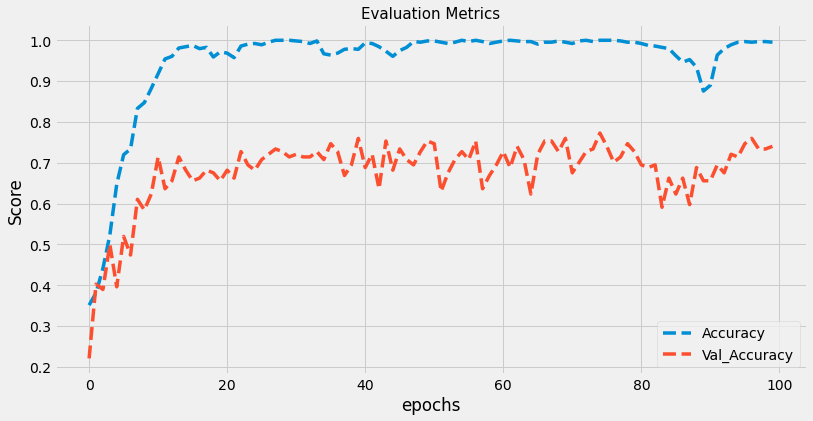

In [43]:
# train accuracy vs val accuracy for model with the first layer as maxpool
acc_max_pool=history_max_pool.history['accuracy']
val_acc_max_pool=history_max_pool.history['val_accuracy']
loss_max_pool=history_max_pool.history['loss']
val_loss_max_pool=history_max_pool.history['val_loss']
epochs_max_pool=range(len(acc_max_pool))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(epochs_max_pool,acc_max_pool,label = 'Accuracy',ls='--',lw=3.5)
plt.plot(epochs_max_pool,val_acc_max_pool,label = 'Val_Accuracy',ls='--',lw=3.5)
plt.title('Evaluation Metrics',size=15)
plt.ylabel('Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

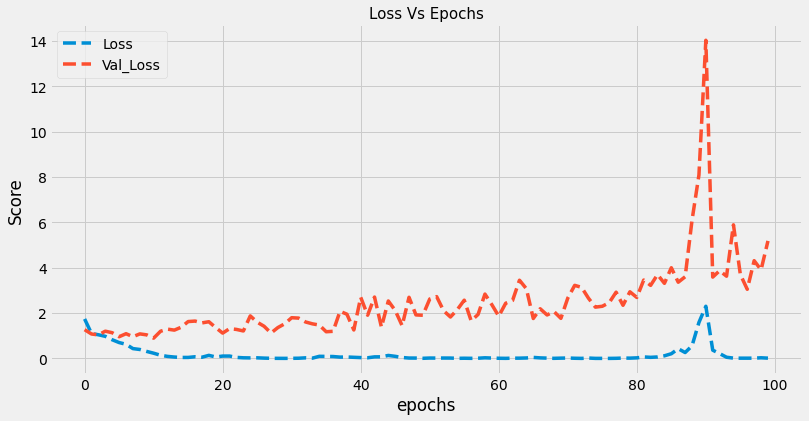

In [44]:
# train loss vs val loss for model with the first layer as maxpool
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(epochs_max_pool,loss_max_pool,label = 'Loss',ls='--',lw=3.5)
plt.plot(epochs_max_pool,val_loss_max_pool,label = 'Val_Loss',ls='--',lw=3.5)
plt.title('Loss Vs Epochs',size=15)
plt.ylabel('Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

# Model 3 (Final Model)

In [45]:
# defining the model
# model= tf.keras.Sequential([MaxPooling2D(2,2,input_shape=(490,1008,3)),
#                          Conv2D(32,3,activation='relu',padding='same'),
#                          MaxPooling2D(2,2),
#                          Conv2D(64,3,activation='relu',padding='same'),
#                          MaxPooling2D(2,2,padding='same'),
#                          #keras.layers.Dropout(0.5),
#                          Conv2D(128,3,activation='relu'),
#                          Flatten(),
#                          Dense(3, activation='softmax')       
#                         ]) 
from tensorflow import keras
model= keras.Sequential([keras.layers.AveragePooling2D(6,3,input_shape=(490,1008,3)),
                                          
                         keras.layers.Conv2D(64,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2,padding='same'),

                         keras.layers.Conv2D(64,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2,padding='same'),

                         keras.layers.Conv2D(128,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2),

                         keras.layers.Conv2D(128,3,padding='same'),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.MaxPooling2D(2,2,padding='same'),

                         keras.layers.Flatten(),
                         keras.layers.Dropout(0.5),
                         keras.layers.Dense(512),
                         keras.layers.LeakyReLU(alpha=0.3),
                         keras.layers.Dense(3, activation='softmax')       
                        ])  

#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
 #   decay_steps=10000,
 #   decay_rate=0.9)
#optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss= keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history_leaky=model.fit(Image_array,train_Label_data,epochs=100,batch_size=32,validation_data=(Image_Val_array,Val_Label_data))

Epoch 1/100
20/20 [==============================] - 5s 206ms/step - loss: 2.5979 - accuracy: 0.3134 - val_loss: 1.1480 - val_accuracy: 0.2208
Epoch 2/100
20/20 [==============================] - 4s 191ms/step - loss: 1.1309 - accuracy: 0.3660 - val_loss: 1.0940 - val_accuracy: 0.3961
Epoch 3/100
20/20 [==============================] - 4s 197ms/step - loss: 1.1080 - accuracy: 0.3422 - val_loss: 1.1327 - val_accuracy: 0.3831
Epoch 4/100
20/20 [==============================] - 4s 195ms/step - loss: 1.0640 - accuracy: 0.4158 - val_loss: 1.0258 - val_accuracy: 0.5065
Epoch 5/100
20/20 [==============================] - 4s 190ms/step - loss: 1.0022 - accuracy: 0.4780 - val_loss: 1.1503 - val_accuracy: 0.4026
Epoch 6/100
20/20 [==============================] - 4s 196ms/step - loss: 1.0141 - accuracy: 0.5167 - val_loss: 1.3469 - val_accuracy: 0.4026
Epoch 7/100
20/20 [==============================] - 4s 199ms/step - loss: 0.9423 - accuracy: 0.5316 - val_loss: 1.0357 - val_accuracy: 0.4740

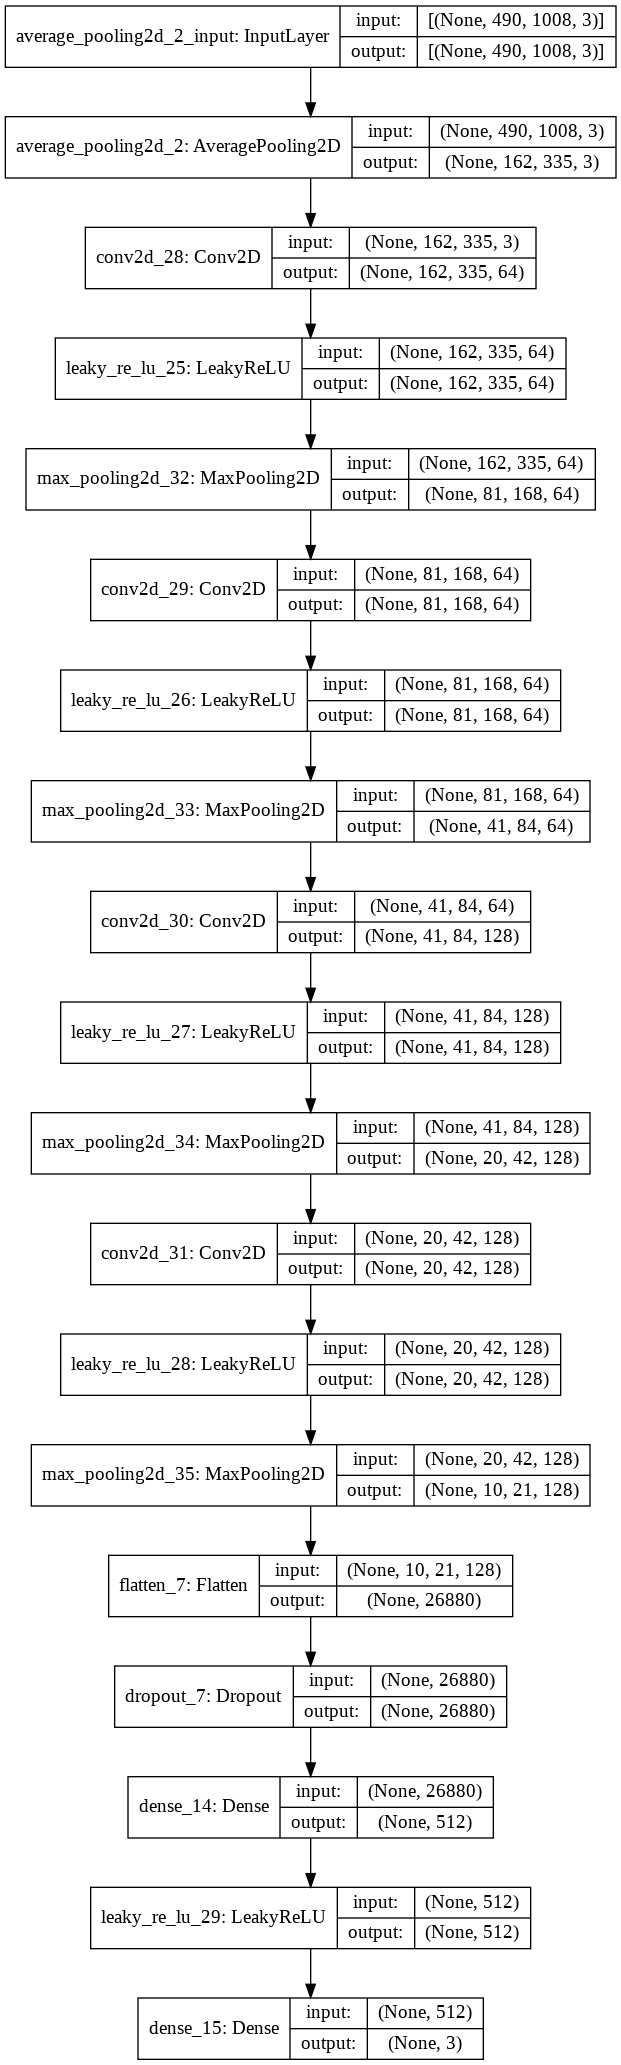

In [46]:
keras.utils.plot_model(model,show_shapes = True)

In [47]:
# fetching model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_2 (Average (None, 162, 335, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 162, 335, 64)      1792      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 162, 335, 64)      0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 81, 168, 64)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 81, 168, 64)       36928     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 81, 168, 64)       0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 41, 84, 64)       

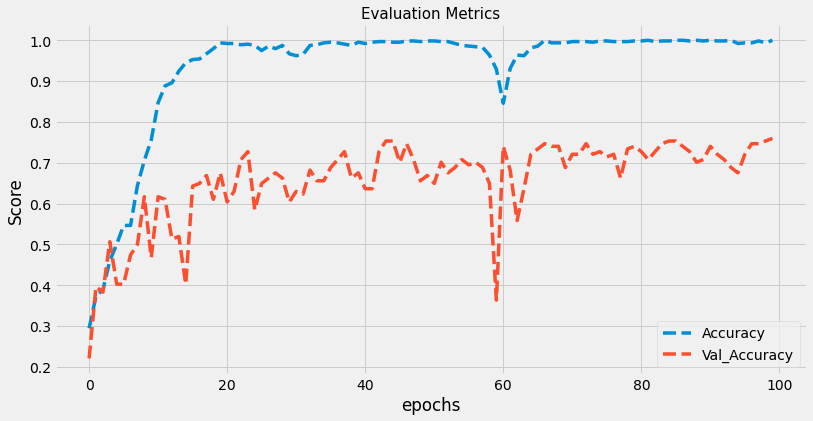

In [48]:
# plots
acc_leaky=history_leaky.history['accuracy']
val_acc_leaky=history_leaky.history['val_accuracy']
loss_leaky=history_leaky.history['loss']
val_loss_leaky=history_leaky.history['val_loss']
epochs_leaky=range(len(acc_leaky))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(epochs_leaky,acc_leaky,label = 'Accuracy',ls='--',lw=3.5)
plt.plot(epochs_leaky,val_acc_leaky,label = 'Val_Accuracy',ls='--',lw=3.5)
plt.title('Evaluation Metrics',size=15)
plt.ylabel('Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

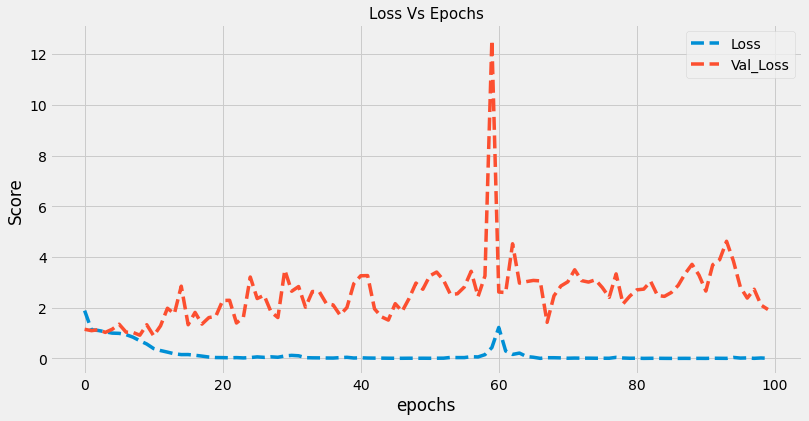

In [49]:
# plots
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
plt.plot(epochs_leaky,loss_leaky,label = 'Loss',ls='--',lw=3.5)
plt.plot(epochs_leaky,val_loss_leaky,label = 'Val_Loss',ls='--',lw=3.5)
plt.title('Loss Vs Epochs',size=15)
plt.ylabel('Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [50]:
model.evaluate(Image_test_array,Test_label)

1/1 [==============================] - 0s 273ms/step - loss: 0.6899 - accuracy: 0.8000


[0.6898552179336548, 0.800000011920929]

In [51]:
#saving the model and using it for prediction
from keras.models import load_model

model.save('model.h5') 
Final_model = load_model('model.h5') 

#Predictions_list=[]
#Image_list=[]
for i in range (len(Test_data)):
 # Image.open(Test_data[i]).resize((245,504))
  classes=(Final_model.predict(np.reshape(Image_test_array[i],[1,490,1008,3])>0.5).astype("int32"))
  Image.open(Test_data[i]).resize((504,245)) 
  print (classes) 
#Image_test_array[3].shape 


[[1 0 0]]
[[0 0 0]]
[[1 0 0]]
[[1 0 0]]
[[0 0 1]]
[[0 0 1]]
[[0 1 0]]
[[0 1 0]]
[[0 1 0]]
[[0 0 1]]


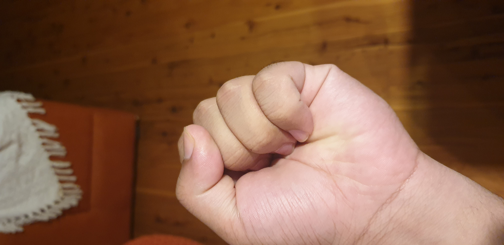

In [ ]:
Image.open(Test_data[5]).resize((504,245))

In [ ]:
Test_data[4]

'/content/drive/MyDrive/DataMiningProjectDataValidation/Rock/20201225_203914.jpg'

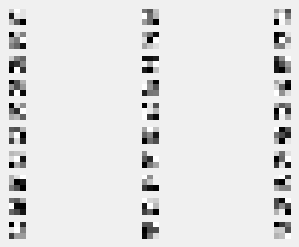

In [52]:
# visualising 6 filters of the first layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 10, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_2_input (I [(None, 490, 1008, 3)]    0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 162, 335, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 162, 335, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


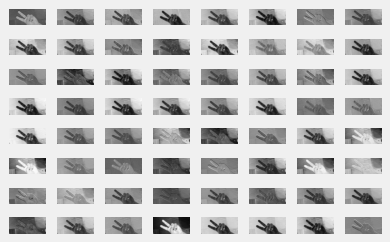

In [53]:
# visualising the ouput feature maps of the first layer
# altering the model to give output after the execution of the first layer

model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
img = load_img(Test_data[5], target_size=(490,1008))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
"""
  Label names:
  0 -> Rock
  1 -> Paper
  2 -> Scissor
"""